# <center>CS 7324 Lab 4
## <center>Francesco Trozzi (47779944) - George Sammit (04010135) - Megan Simons (46334773)

# Load, Split, and Balance

### Imports

In [166]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings

### Load the data
Load the data, and drop any rows with missing columns.  We also drop county as directed in class and TractId.  State is integer encoded below.

In [167]:
warnings.filterwarnings('ignore')
df = pd.read_csv('acs2017_census_tract_data.csv')
print("Unique counties in the dataset: ", len(df['County'].unique()))
df.drop(columns=['County'], inplace=True)
df.drop(columns=['TractId'], inplace=True)
df.head()

Unique counties in the dataset:  1955


,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Alabama,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,Alabama,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,Alabama,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,Alabama,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,Alabama,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [168]:
x,y = np.where(pd.isnull(df))
print("Unique rows with an empty value before cleaning: ", len(np.unique(x)))
df.dropna(axis=0, how='any', inplace=True)
x,y = np.where(pd.isnull(df))
print("Unique rows with an empty value afert cleaning: ", len(np.unique(x)))

Unique rows with an empty value before cleaning:  1283
Unique rows with an empty value afert cleaning:  0


In [169]:
print("Unique states before conversion: ", len(df['State'].unique()))
df['State'] = df['State'].rank(method='dense', ascending=False).astype(int)
print("Unique states before conversion: ", len(df['State'].unique()))

Unique states before conversion:  52
Unique states before conversion:  52


### Split & Balance the Data

We did find information (https://www.prb.org/insight/u-s-poverty-thresholds-and-poverty-guidelines-whats-the-difference/) regarding poverty thresholds (used to determine minimum income to meet basic needs) and guidelines (used to determine eligibility for certain programs) in the US.  In this case thresholds are probably more appropriate.  However, they only offer two caregories of above or below.  Guidleines are often further divided into percentages of the thresholds, e.g. 125% of the poverty line.  Regardless, both are based on the number of family members and household income which we do not have.  In 2017, Statista reports an average of 2.54 persons/household (https://www.statista.com/statistics/183648/average-size-of-households-in-the-us/).  Of course, we have the thresholds for 2017, so that effectively leaves us with two choices:
* Attempt to find some threshold based on the reported income and average number of family members, and then manipulate the child poverty rate into categories based on that formula
* Simply taking the various child poverty rates as they are, and split them into four equal categories

Given that we have data from close to 2K counties (see above), we believe that the latter is a more appropriate approach as it does not rely on any data manipulation based on assumptions.  In fact, as you will see, this split tends to agree with https://www.childtrends.org/indicators/children-in-poverty#:~:text=In%202017%2C%20slightly%20less%20than,risen%20during%20the%20Great%20Recession which categorizes the poverty rates as 8% at 50% of the poverty line, 17.5% at the line, and 38.8% under 200% of the line

Finally, we choose an approach that balances the data before splitting it into train/test data.  In this case, we believe that it prersents a more realistic view of the data.

In [170]:
df['ChildPoverty'].describe()

count    72718.000000
mean        21.148476
std         18.572714
min          0.000000
25%          6.200000
50%         16.300000
75%         31.600000
max        100.000000
Name: ChildPoverty, dtype: float64

In [171]:
# Quantize child poverty rate by quartile
Y, bins = pd.qcut(df['ChildPoverty'],4, labels=False, retbins=True)
df.drop(columns=['ChildPoverty'], inplace=True)
print(bins)

[  0.    6.2  16.3  31.6 100. ]


In [172]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2)
print("X training shape: ", X_train.shape)
print("X testing shape: ", X_test.shape)
print("-----")
print("Y training shape: ", y_train.shape)
print("Y testing shape: ", y_test.shape)
print("-----")
print("Note that lower indicies equate to less poverty")
for rate in np.unique(y_train):
    print("Training rows with a poverty rate of {}: {}".format(rate, np.count_nonzero(y_train == rate)))
for rate in np.unique(y_test):
    print("Tesing rows with a poverty rate of {}: {}".format(rate, np.count_nonzero(y_test == rate)))

X training shape:  (58174, 34)
X testing shape:  (14544, 34)
-----
Y training shape:  (58174,)
Y testing shape:  (14544,)
-----
Note that lower indicies equate to less poverty
Training rows with a poverty rate of 0: 14536
Training rows with a poverty rate of 1: 14538
Training rows with a poverty rate of 2: 14512
Training rows with a poverty rate of 3: 14588
Tesing rows with a poverty rate of 0: 3693
Tesing rows with a poverty rate of 1: 3633
Tesing rows with a poverty rate of 2: 3636
Tesing rows with a poverty rate of 3: 3582


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72718 non-null  int32  
 1   TotalPop          72718 non-null  int64  
 2   Men               72718 non-null  int64  
 3   Women             72718 non-null  int64  
 4   Hispanic          72718 non-null  float64
 5   White             72718 non-null  float64
 6   Black             72718 non-null  float64
 7   Native            72718 non-null  float64
 8   Asian             72718 non-null  float64
 9   Pacific           72718 non-null  float64
 10  VotingAgeCitizen  72718 non-null  int64  
 11  Income            72718 non-null  float64
 12  IncomeErr         72718 non-null  float64
 13  IncomePerCap      72718 non-null  float64
 14  IncomePerCapErr   72718 non-null  float64
 15  Poverty           72718 non-null  float64
 16  Professional      72718 non-null  float6

In [174]:
df.head()

,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,52,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,52,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,52,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,52,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,52,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


# Pre-processing   

### Dr. Larson's Code

In [175]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian_ Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    

class TLPDropout(TLPMiniBatchCrossEntropy):
    def __init__(self, dropout=0.25, **kwds):        
        # need to add to the original initializer 
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            
            if self.dropout>0.0:
                
                # randomly select half of the neurons
                idx_dropout = np.random.permutation(W1.shape[0])
                #idx_other_half = idx_dropout[:int(W1.shape[0]*self.dropout)]
                idx_dropout = idx_dropout[int(W1.shape[0]*(1-self.dropout)):] #drop half
                    
                idx_dropout = np.sort(idx_dropout)
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                W1 = W1[idx_dropout,:]# get rid of rows
                W2 = W2[:,idx_W2_withbias]# get rid of extra columns
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                
            
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2)
                
                cost = self._cost(A3,Y_enc[:, idx],W1,W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=W1,W2=W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout = delta_W1, delta_W2

            if self.dropout>0.0:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                self.W2[:,idx_W2_withbias] = W2
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                delta_W2_prev[:,idx_W2_withbias] = delta_W2_prev_dropout
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self
    
class TLPBetterInitial(TLPDropout):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
class TLPReLu(TLPBetterInitial):
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        #Xavier Glorot, Yoshua Bengio ; 
        #  Understanding the difficulty of training deep feedforward neural networks
        #  Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010.
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
        
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2) # never use relu as last layer for classification (yuck!)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) 
        
        # V3[Z2<=0] = 0 # could can change to be relu back prop on this layer too!
        
        # old update: V1 = A2*(1-A2)*(W2.T @ V2)
        # the derivative of sigmoid was A2(1-A2), but now that is relu
        # so we change it to:
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        V1 = (W2.T @ V2) 
        V1[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2

In [176]:
def run_and_print_results(nn, X_train, y_train, X_test, y_test):
    """ Adapted from Dr. Larson's code
    """
    nn.fit(X_train.to_numpy(), y_train.to_numpy(), print_progress=0)

    yhat = nn.predict(X_train)
    print('Training Accuracy:', accuracy_score(y_train, yhat))
    yhat = nn.predict(X_test)
    print('Test Accuracy:', accuracy_score(y_test, yhat))
    print('Test Confusion')
    print(confusion_matrix(y_test, yhat))
    
    plt.plot(range(len(nn.score_)), nn.score_, color="red", label="Accuracy")
    plt.ylabel('Training Accuracy')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    cost_avgs = [np.nanmean(mincost) for mincost in nn.cost_]
    plt.plot(range(len(cost_avgs)), cost_avgs, color="blue",label="Cost")
    plt.ylabel('Training Cost')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    
    return yhat

### Two-layer Perceptron Performance
No normalization or one-hot encoding

In [177]:
# Used for all tests
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':30, 'eta':0.001, 
         'alpha':1e-4, 'decrease_const':1e-9, 'minibatches':600,
         'shuffle':True,'random_state':1, 'dropout':0.0}

Training Accuracy: 0.24945852098875787
Test Accuracy: 0.25
Test Confusion
[[   0    0 3693    0]
 [   0    0 3633    0]
 [   0    0 3636    0]
 [   0    0 3582    0]]


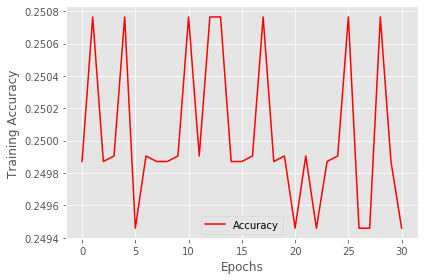

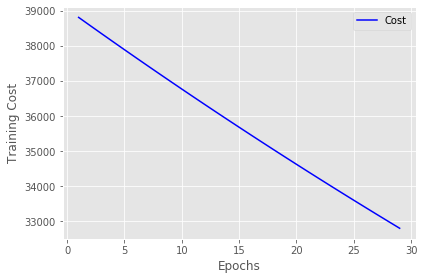

In [178]:
nn = TLPReLu(**vals)
yhat_raw = run_and_print_results(nn, X_train, y_train, X_test, y_test)

### Normalize Feature Data
Here is the breakdown of our fetures:
* **Categorical:** State
* **Counts:** TotalPop, Men, Women, VotingAgeCitizen, Employed
* **Percentages:** Hispanic, White, Black, Native, Asian, Pacific, Poverty, Professional, Service, Office, Construction, Production, Drive, Carpool, Transit, Walk, OtherTransp, WorkAtHome, Employed, PrivateWork, PublicWork, SelfEmployed, FamilyWork, Unemployment
* **Dollar Amounts:** Income, IncomeErr, IncomePerCap, IncomePerCapErr
* **Times:** MeanCommute

Looking at the distribution graphs in Kaggle, some of these appear to follow a Gaussian distribution, but most do not, so we planned to normalize (MinMaxScaler) rather than standardize (StandardScaler).  We went with the suggestion from class to standardize

In [179]:
# Normalize all but state
normalizer = StandardScaler().fit(X_train[X_train.columns.difference(['State'])])
X_train[X_train.columns.difference(['State'])] = normalizer.transform(X_train[X_train.columns.difference(['State'])])
X_test[X_test.columns.difference(['State'])] = normalizer.transform(X_test[X_test.columns.difference(['State'])])

Training Accuracy: 0.6246948808746176
Test Accuracy: 0.6281628162816282
Test Confusion
[[1731 1527  396   39]
 [ 195 1606 1778   54]
 [  16  233 2737  650]
 [  16    4  500 3062]]


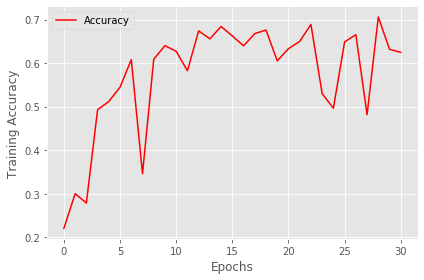

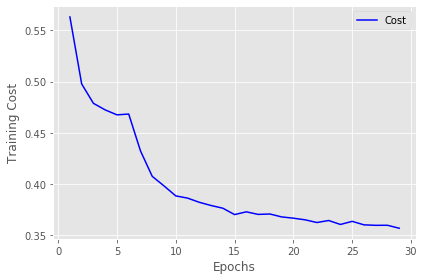

In [180]:
nn = TLPReLu(**vals)
yhat_scaled = run_and_print_results(nn, X_train, y_train, X_test, y_test)

### Normalize & One Hot Encode Feature Data

In [181]:
# Train
one_hot_state = pd.get_dummies(X_train.State, prefix='State')
X_train.drop(columns=['State'], inplace=True)
X_train = pd.concat([X_train, one_hot_state], axis=1)

# Test
one_hot_state = pd.get_dummies(X_test.State, prefix='State')
X_test.drop(columns=['State'], inplace=True)
X_test = pd.concat([X_test, one_hot_state], axis=1)

Training Accuracy: 0.7453673462371506
Test Accuracy: 0.735492299229923
Test Confusion
[[2838  746   70   39]
 [ 533 2323  707   70]
 [  42  578 2434  582]
 [  17   15  448 3102]]


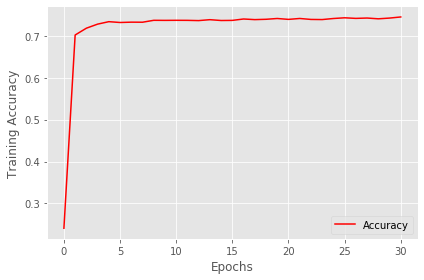

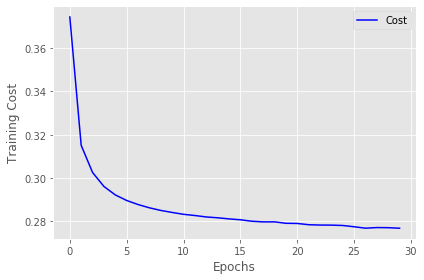

In [182]:
nn = TLPReLu(**vals)
yhat_ohe = run_and_print_results(nn, X_train, y_train, X_test, y_test)

### Compare the Above

It is difficult to determine whether the models perform differently based solely on accuracy and cost evaluation. Instead, we need to determine if there is a statistically significant difference in proportions between paired data using the McNemar test. Even though the chi-squared statistic seems to be abnormally large for all comparisons, all three model comparisons have a p-value of 0.000. All the p-values are less than 0.05 (using a confidence interval of 95%), so this leads us to reject our null hypothesis. Rejecting our null hypothesis means that we can say that there is a meaningful difference in the three performances.  Regarding the difference in performance, we attribute that to the difference between Arizonia (1) and Wyomeing (52) before one-hot encoding.  Likewise, there is a huge differnece between percentages (e.g Hispanic) and counts (e.g VotingAgeCitizen) which causes certain features to overtake others during the learning process. This phenomenon can be attributed to the considerable differences in dynamic ranges of these features. 

In [183]:
y_test = list(y_test)
raw_comp = np.equal(yhat_raw, y_test)
scaled_comp = np.equal(yhat_scaled, y_test)
ohe_comp = np.equal(yhat_ohe, y_test)

def table_compiler(model1, model2):

    len1, len2 = len(model1), len(model2)
    if len1 != len2:
        print('Error: models hould have same lenght as they should be from same testing set')

    # Initialize table
    table = np.zeros((2,2))
    
    #fill the table
    for i in range(len1):
        if model1[i] == True and model2[i] == True:
            table[0][0] += 1
        elif model1[i] == True and model2[i] == False:
            table[0][1] += 1
        elif model1[i] == False and model2[i] == True:
            table[1][0] += 1
        elif model1[i] == False and model2[i] == False:
            table[1][1] += 1
            
    return table

raw_scaled_table = table_compiler(raw_comp, scaled_comp)
raw_ohe_table = table_compiler(raw_comp, ohe_comp)
ohe_scaled_table = table_compiler(scaled_comp, ohe_comp)

In [184]:
from statsmodels.stats.contingency_tables import mcnemar

tables = [raw_scaled_table, raw_ohe_table, ohe_scaled_table]
tables_titles = ['No processing vs Scaled features', 'No processing vs Scaled and Encoded Features', 'Scaled vs Scaled and Encoded features']

for t in range(len(tables)):
    print(tables_titles[t])
    # calculate mcnemar test
    result = mcnemar(tables[t], exact=False)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('No meaningful difference in performance (fail to reject H0)')
        print('-----------------------------------------------------------')
        print()
    else:
        print('Meaningful difference in performance (reject H0)')
        print('------------------------------------------------')
        print()

No processing vs Scaled features
statistic=4143.464, p-value=0.000
Meaningful difference in performance (reject H0)
------------------------------------------------

No processing vs Scaled and Encoded Features
statistic=5266.096, p-value=0.000
Meaningful difference in performance (reject H0)
------------------------------------------------

Scaled vs Scaled and Encoded features
statistic=659.334, p-value=0.000
Meaningful difference in performance (reject H0)
------------------------------------------------



# Modeling 

In [157]:
def print_n_plot(nn, plot_acc=True, print_acc=True, print_cost=True, plot_cost=True, print_grad=True, plot_grad=True):
    
    if print_acc==True:
        if hasattr(nn,'score_'):
            for i in range(len(nn.score_)):
                print('Epoch: '+str(i))
                print('Training Accuracy: '+str(nn.score_[i]))
                
    if plot_acc==True:
        plt.figure(figsize=[10,5])
        if hasattr(nn,'score_'):
            avg_cost = []
            plt.plot(range(len(nn.score_)), nn.score_)

        plt.xticks(range(len(nn.score_)), labels=range(len(nn.score_)))
        plt.xlabel('Epochs')
        plt.ylabel('Training accuracy')
        plt.title('Training accuracy vs Epoch')
        plt.tight_layout()
    
    if print_grad==True:
        if hasattr(nn,'grads_epoch_avg_'):
            for i in range(nn.grads_epoch_avg_.shape[0]):
                print('Epoch: '+str(i))
                print('Average magnitude gradient:')
                for l in range(nn.grads_epoch_avg_.shape[1]):
                    print('Layer '+str(l)+': '+str(nn.grads_epoch_avg_[i][l]))

                    
    if plot_grad==True:
        plt.figure(figsize=[10,5])
        if hasattr(nn,'grads_epoch_avg_'):
            for l in range(nn.grads_epoch_avg_.shape[1]):
                plt.plot(range(len(nn.grads_epoch_avg_)), nn.grads_epoch_avg_[:,l], label='Layer '+str(l+1))

            plt.xticks(range(len(nn.grads_epoch_avg_)), labels=range(len(nn.grads_epoch_avg_)))
            plt.xlabel('Epochs')
            plt.ylabel('Avg abolute gradient')
            plt.title('Avg abolute gradient VS Epoch')
            plt.tight_layout()
            plt.legend(loc='best')
            
            
    if print_cost==True:
        if hasattr(nn,'cost_'):
            for i in range(len(nn.cost_)):
                print('Epoch: '+str(i))
                print('Cost: '+str(np.mean(nn.cost_[i])))

                    
    if plot_cost==True:
        plt.figure(figsize=[10,5])
        if hasattr(nn,'cost_'):
            avg_cost = []
            for i in range(len(nn.cost_)):
                avg_cost.append(np.mean(nn.cost_[i]))
    
            plt.plot(range(len(nn.cost_)), avg_cost)

        plt.xticks(range(len(nn.cost_)), labels=range(len(nn.cost_)))
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
        plt.title('Cost vs Epoch')
        plt.tight_layout()

### Third Layer Support 

In [154]:
class ThreeLayerPerceptron(object):
    def __init__(self, n_hidden=30, n_hidden2=20, dropout=0.25, clipping=True,
                 C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):
        np.random.seed(random_state)
        self.clipping = clipping
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.dropout = dropout
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot
      
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden2 + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden2 + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden2 + 1)) 
        W3[:,:1] = 0
        
        return W1, W2, W3
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3):

        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        
        V3 = (A4 - Y_enc)  
        V2 = (W3.T @ V3) 
        V1 = (W2.T @ V2[1:])
        
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        
        V1[Z1_with_bias<=0] = 0
        V2[Z2_with_bias<=0] = 0
        
        grad3 = V3 @ A3.T # no bias on final layer
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C

        return grad1, grad2, grad3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2,  self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

    def _clipping(self,grad):
        grad[grad > 0.5] = 0.5
        grad[grad < -0.5] = -0.5
        return grad
        
    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        delta_W3_prev = np.zeros(self.W3.shape)
        
        self.grads_epoch_avg_ = np.zeros((self.epochs, 3))
        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            W3 = self.W3.copy()
            
            if self.dropout>0.0:
                
                # randomly select half of the neurons
                idx_dropout = np.random.permutation(W1.shape[0])
                idx_dropout = idx_dropout[int(W1.shape[0]*(1-self.dropout)):] #drop half
                idx_dropout = np.sort(idx_dropout)
                
                idx2_dropout = np.random.permutation(W2.shape[0])
                idx2_dropout = idx2_dropout[int(W2.shape[0]*(1-self.dropout)):] #drop half
                idx2_dropout = np.sort(idx2_dropout)
                
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                idx_W3_withbias = np.hstack(([0],(idx2_dropout+1)))
                W1 = W1[idx_dropout,:]
                W2 = W2[:,idx_W2_withbias]
                W2 = W2[idx2_dropout,:]
                W3 = W3[:,idx_W3_withbias]
                
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
                delta_W2_prev_dropout = delta_W2_prev_dropout[idx2_dropout,:]
                delta_W3_prev_dropout = delta_W3_prev[:,idx_W3_withbias]
                
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                delta_W3_prev_dropout = delta_W3_prev
            
            grad1_mini_avg, grad2_mini_avg, grad3_mini_avg = [], [], []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2, 
                                                       W3)
                
                cost = self._cost(A4,Y_enc[:, idx],W1,W2,W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=W1, W2=W2, W3=W3)
                
                # clipping to tame gradients (just in case... you never know)
                if self.clipping == True:
                    grad1 = self._clipping(grad1)
                    grad2 = self._clipping(grad2)
                    grad3 = self._clipping(grad3)

                    
                delta_W1, delta_W2, delta_W3 = self.eta * grad1, self.eta * grad2, self.eta * grad3

                 
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                W3 -= (delta_W3 + (self.alpha * delta_W3_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout, delta_W3_prev_dropout = delta_W1, delta_W2, delta_W3
            
                #Get gradients for each minibatch
                grad1_mini_avg.append(grad1)
                grad2_mini_avg.append(grad2)
                grad3_mini_avg.append(grad3)
            
            # Mean absolute values for each epoch
            self.grads_epoch_avg_[i][0] = np.mean(np.absolute(grad1_mini_avg))
            self.grads_epoch_avg_[i][1] = np.mean(np.absolute(grad2_mini_avg))
            self.grads_epoch_avg_[i][2] = np.mean(np.absolute(grad3_mini_avg))

            if self.dropout>0.0:
               
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                for i in range(len(idx2_dropout)):
                    for j in range(len(idx_W2_withbias)):
                        self.W2[idx2_dropout[i],idx_W2_withbias[j]] = W2[i,j]

                self.W3[:,idx_W3_withbias] = W3
                
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                
                for i  in range(len(idx2_dropout)):
                    for j in range(len(idx_W2_withbias)):
                        delta_W2_prev[idx2_dropout[i],idx_W2_withbias[j]] = delta_W2_prev_dropout[i,j]
    
                delta_W3_prev[:,idx_W3_withbias] = delta_W3_prev_dropout
                
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                self.W3 = W3
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                delta_W3_prev = delta_W3_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise

        return self

In [187]:
vals2 = {'n_hidden':60, 'n_hidden2':50,
         'C':1e-2, 'epochs':50, 'eta':0.001, 
         'alpha':1e-4, 'decrease_const':1e-9, 'minibatches':600,
         'shuffle':True,'random_state':1, 'dropout':0.0}

nn = ThreeLayerPerceptron(**vals2)
nn.fit(X_train.to_numpy(), y_train.to_numpy(), print_progress=0)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))
print(confusion_matrix(y_test,yhat))

Accuracy: 0.7277227722772277
[[2763  833   67   30]
 [ 539 2339  703   52]
 [  41  633 2418  544]
 [  26   13  479 3064]]


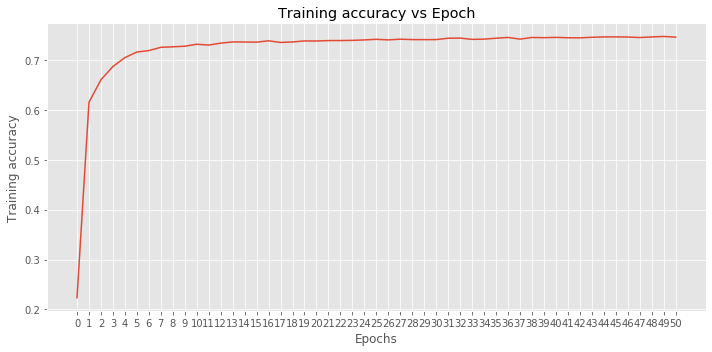

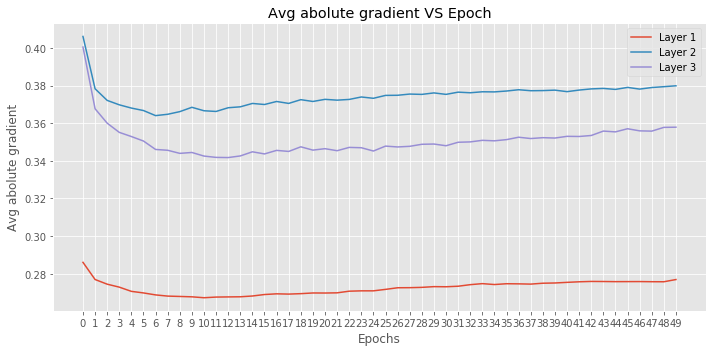

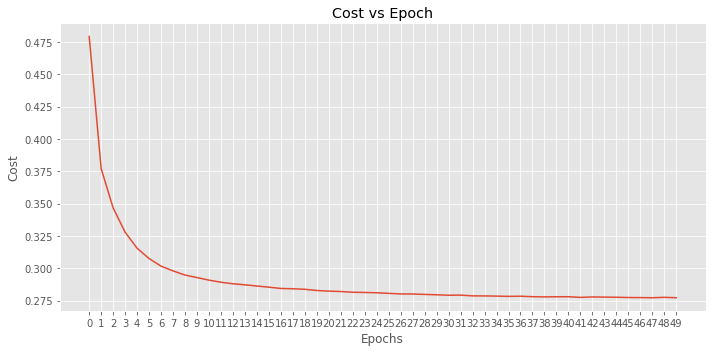

In [188]:
print_n_plot(nn,print_acc=False, print_grad=False, print_cost=False)

### Fourth Layer Support 

In [159]:
class FourLayerPerceptron(object):
    def __init__(self, n_hidden=30, n_hidden2=30, n_hidden3=30, dropout=0.25, clipping=True,
                 C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):
        np.random.seed(random_state)
        self.clipping = clipping
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.dropout = dropout
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden2 + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden3 + self.n_hidden2 + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2 + 1)) 
        W3[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden3 + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden3 + 1)) 
        W4[:,:1] = 0
        
        return W1, W2, W3, W4
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2))
    
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A5)+(1-Y_enc)*np.log(1-A5))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4):

        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._relu(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)

        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
    
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation.
        """

        # vectorized backpropagation for relu
        V4 = (A5 - Y_enc)  # last layer sensitivity
        V3 = (W4.T @ V4)
        V2 = (W3.T @ V3[1:])
        V1 = (W2.T @ V2[1:])
        
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        Z3_with_bias = self._add_bias_unit(Z3,how='row')
        
        V1[Z1_with_bias<=0] = 0
        V2[Z2_with_bias<=0] = 0
        V3[Z3_with_bias<=0] = 0

        grad4 = V4 @ A4.T # no bias on final layer
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
            
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred
    
    def _clipping(self,grad):
        grad[grad > 0.5] = 0.5
        grad[grad < -0.5] = -0.5
        return grad 
        
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        delta_W3_prev = np.zeros(self.W3.shape)
        delta_W4_prev = np.zeros(self.W4.shape)
        
        self.grads_epoch_avg_ = np.zeros((self.epochs, 4))
        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))

        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            W3 = self.W3.copy()
            W4 = self.W4.copy()
            
            if self.dropout>0.0:
                
                # randomly select half of the neurons
                idx_dropout = np.random.permutation(W1.shape[0])
                #idx_other_half = idx_dropout[:int(W1.shape[0]*self.dropout)]
                idx_dropout = idx_dropout[int(W1.shape[0]*(1-self.dropout)):] #drop half
                idx_dropout = np.sort(idx_dropout)
                
                idx2_dropout = np.random.permutation(W2.shape[0])
                idx2_dropout = idx2_dropout[int(W2.shape[0]*(1-self.dropout)):] #drop half
                idx2_dropout = np.sort(idx2_dropout)
                
                idx3_dropout = np.random.permutation(W3.shape[0])
                idx3_dropout = idx3_dropout[int(W3.shape[0]*(1-self.dropout)):] #drop half
                idx3_dropout = np.sort(idx3_dropout)
                
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                idx_W3_withbias = np.hstack(([0],(idx2_dropout+1)))
                idx_W4_withbias = np.hstack(([0],(idx3_dropout+1)))
                W1 = W1[idx_dropout,:]
                W2 = W2[:,idx_W2_withbias]
                W2 = W2[idx2_dropout,:]
                W3 = W3[:,idx_W3_withbias]
                W3 = W3[idx3_dropout,:]
                W4 = W4[:,idx_W4_withbias]
                
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
                delta_W2_prev_dropout = delta_W2_prev_dropout[idx2_dropout,:]
                delta_W3_prev_dropout = delta_W3_prev[:,idx_W3_withbias]
                delta_W3_prev_dropout = delta_W3_prev_dropout[idx3_dropout,:]
                delta_W4_prev_dropout = delta_W4_prev[:,idx_W4_withbias]

            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                delta_W3_prev_dropout = delta_W3_prev
                delta_W4_prev_dropout = delta_W4_prev
            
            grad1_mini_avg, grad2_mini_avg, grad3_mini_avg, grad4_mini_avg = [], [], [], []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx],
                                                       W1, W2, W3, W4)
                
                cost = self._cost(A5,Y_enc[:, idx],W1,W2,W3,W4)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5,
                                                                Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                                                                Y_enc=Y_enc[:, idx],
                                                                W1=W1, W2=W2, W3=W3, W4=W4)
                
                if self.clipping == True:
                    grad1 = self._clipping(grad1)
                    grad2 = self._clipping(grad2)
                    grad3 = self._clipping(grad3)
                    grad4 = self._clipping(grad4)
                

                delta_W1, delta_W2, delta_W3, delta_W4 = self.eta * grad1, self.eta * grad2, self.eta * grad3, self.eta * grad4
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                W3 -= (delta_W3 + (self.alpha * delta_W3_prev_dropout))
                W4 -= (delta_W4 + (self.alpha * delta_W4_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout, delta_W3_prev_dropout, delta_W4_prev_dropout = delta_W1, delta_W2, delta_W3, delta_W4

                            
                #Get gradients for each minibatch
                grad1_mini_avg.append(grad1)
                grad2_mini_avg.append(grad2)
                grad3_mini_avg.append(grad3)
                grad4_mini_avg.append(grad4)
            
            # Mean absolute values for each epoch
            self.grads_epoch_avg_[i][0] = np.mean(np.absolute(grad1_mini_avg))
            self.grads_epoch_avg_[i][1] = np.mean(np.absolute(grad2_mini_avg))
            self.grads_epoch_avg_[i][2] = np.mean(np.absolute(grad3_mini_avg))
            self.grads_epoch_avg_[i][3] = np.mean(np.absolute(grad4_mini_avg))
                
            if self.dropout>0.0:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                for i  in range(len(idx2_dropout)):
                    for j in range(len(idx_W2_withbias)):
                        self.W2[idx2_dropout[i],idx_W2_withbias[j]] = W2[i,j]
                        
                for i  in range(len(idx3_dropout)):
                    for j in range(len(idx_W3_withbias)):
                        self.W3[idx3_dropout[i],idx_W3_withbias[j]] = W3[i,j]
                        
                self.W4[:,idx_W4_withbias] = W4
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                for i  in range(len(idx2_dropout)):
                    for j in range(len(idx_W2_withbias)):
                        delta_W2_prev[idx2_dropout[i],idx_W2_withbias[j]] = delta_W2_prev_dropout[i,j]
        
                for i  in range(len(idx3_dropout)):
                    for j in range(len(idx_W3_withbias)):
                        delta_W3_prev[idx3_dropout[i],idx_W3_withbias[j]] = delta_W3_prev_dropout[i,j]
                        
                #delta_W2_prev[idx2_dropout][idx_W2_withbias] = delta_W2_prev_dropout
                delta_W4_prev[:,idx_W4_withbias] = delta_W4_prev_dropout
                
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                self.W3 = W3
                self.W4 = W4
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                delta_W3_prev = delta_W3_prev_dropout
                delta_W4_prev = delta_W4_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise

        return self

In [189]:
vals2 = {'n_hidden':60, 'n_hidden2':50, 'n_hidden3':30,
         'C':1e-2, 'epochs':50, 'eta':0.001, 
         'alpha':1e-4, 'decrease_const':1e-9, 'minibatches':600,
         'shuffle':True,'random_state':1, 'dropout':0.0}

nn = FourLayerPerceptron(**vals2)
nn.fit(X_train.to_numpy(), y_train.to_numpy())
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))
print(confusion_matrix(y_test,yhat))

Accuracy: 0.7302667766776678
[[2957  629   82   25]
 [ 664 2152  768   49]
 [  63  553 2597  423]
 [  38    2  627 2915]]


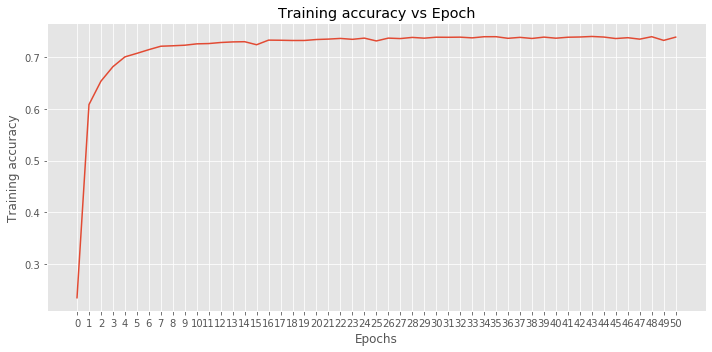

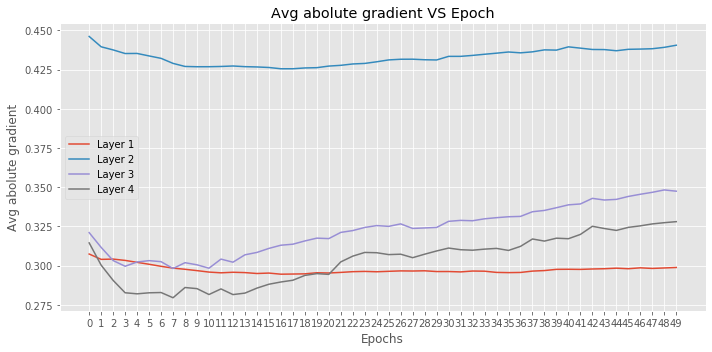

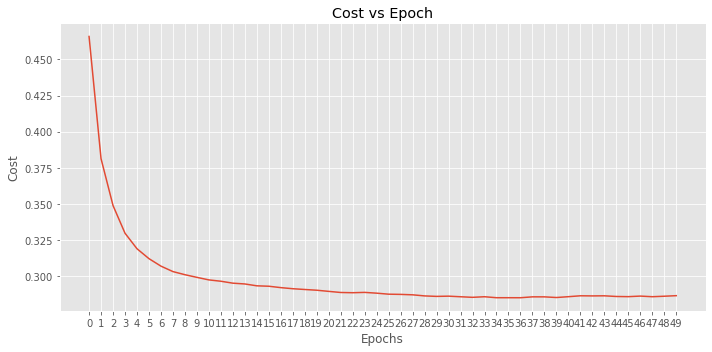

In [190]:
print_n_plot(nn,print_acc=False, print_grad=False, print_cost=False)

### Fifth Layer Support 

In [162]:
class FiveLayerPerceptron(object):
    def __init__(self, n_hidden=70, n_hidden2=50, n_hidden3=30, n_hidden4=20, dropout=0.25, clipping=True,
                 C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):
        np.random.seed(random_state)
        self.clipping= clipping
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.n_hidden4 = n_hidden4
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.dropout = dropout
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden2 + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden3 + self.n_hidden2 + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2 + 1)) 
        W3[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden4 + self.n_hidden3 + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden4, self.n_hidden3 + 1)) 
        W4[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden4 + 1))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden4 + 1)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2)+ np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    
    def _feedforward(self, X, W1, W2, W3, W4, W5):

        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._relu(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._relu(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)

        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """

        # vectorized backpropagation
        V5 = (A6 - Y_enc)  # last layer sensitivity
        V4 = (W5.T @ V5)
        V3 = (W4.T @ V4[1:])
        V2 = (W3.T @ V3[1:])
        V1 = (W2.T @ V2[1:])
        
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        Z3_with_bias = self._add_bias_unit(Z3,how='row')
        Z4_with_bias = self._add_bias_unit(Z4,how='row')
        
        V1[Z1_with_bias<=0] = 0
        V2[Z2_with_bias<=0] = 0
        V3[Z3_with_bias<=0] = 0
        V4[Z4_with_bias<=0] = 0
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T 
        
       # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

    def _clipping(self,grad):
        grad[grad > 0.5] = 0.5
        grad[grad < -0.5] = -0.5
        return grad 
        
    def fit(self, X, y, print_progress=0, XY_test=None, print_grad=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        delta_W3_prev = np.zeros(self.W3.shape)
        delta_W4_prev = np.zeros(self.W4.shape)
        delta_W5_prev = np.zeros(self.W5.shape)
        
        self.grads_epoch_avg_ = np.zeros((self.epochs, 5))
        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
                  
        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            W3 = self.W3.copy()
            W4 = self.W4.copy()
            W5 = self.W5.copy()
            
            if self.dropout>0.0:
                
                # randomly select half of the neurons
                idx_dropout = np.random.permutation(W1.shape[0])
                idx_dropout = idx_dropout[int(W1.shape[0]*(1-self.dropout)):]
                idx_dropout = np.sort(idx_dropout)
                
                idx2_dropout = np.random.permutation(W2.shape[0])
                idx2_dropout = idx2_dropout[int(W2.shape[0]*(1-self.dropout)):]
                idx2_dropout = np.sort(idx2_dropout)
                
                idx3_dropout = np.random.permutation(W3.shape[0])
                idx3_dropout = idx3_dropout[int(W3.shape[0]*(1-self.dropout)):]
                idx3_dropout = np.sort(idx3_dropout)
                
                idx4_dropout = np.random.permutation(W4.shape[0])
                idx4_dropout = idx4_dropout[int(W4.shape[0]*(1-self.dropout)):]
                idx4_dropout = np.sort(idx4_dropout)
                
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                idx_W3_withbias = np.hstack(([0],(idx2_dropout+1)))
                idx_W4_withbias = np.hstack(([0],(idx3_dropout+1)))
                idx_W5_withbias = np.hstack(([0],(idx4_dropout+1)))
                
                W1 = W1[idx_dropout,:]
                W2 = W2[:,idx_W2_withbias]
                W2 = W2[idx2_dropout,:]
                W3 = W3[:,idx_W3_withbias]
                W3 = W3[idx3_dropout,:]
                W4 = W4[:,idx_W4_withbias]
                W4 = W4[idx4_dropout,:]
                W5 = W5[:,idx_W5_withbias]
                
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
                delta_W2_prev_dropout = delta_W2_prev_dropout[idx2_dropout,:]
                delta_W3_prev_dropout = delta_W3_prev[:,idx_W3_withbias]
                delta_W3_prev_dropout = delta_W3_prev_dropout[idx3_dropout,:]
                delta_W4_prev_dropout = delta_W4_prev[:,idx_W4_withbias]
                delta_W4_prev_dropout = delta_W4_prev_dropout[idx4_dropout,:]
                delta_W5_prev_dropout = delta_W5_prev[:,idx_W5_withbias]

            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                delta_W3_prev_dropout = delta_W3_prev
                delta_W4_prev_dropout = delta_W4_prev
                delta_W5_prev_dropout = delta_W5_prev
            
            grad1_mini_avg, grad2_mini_avg, grad3_mini_avg, grad4_mini_avg, grad5_mini_avg = [], [], [], [], []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       W1, W2, W3, W4, W5)
                
                cost = self._cost(A6,Y_enc[:, idx],W1,W2,W3,W4,W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                Y_enc=Y_enc[:, idx],
                                                                W1=W1, W2=W2, W3=W3, W4=W4, W5=W5)

                if self.clipping == True:
                    grad1 = self._clipping(grad1)
                    grad2 = self._clipping(grad2)
                    grad3 = self._clipping(grad3)
                    grad4 = self._clipping(grad4)
                    grad5 = self._clipping(grad5)
                    

                delta_W1, delta_W2, delta_W3, delta_W4, delta_W5 = self.eta * grad1, self.eta * grad2, self.eta * grad3, self.eta * grad4, self.eta * grad5
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                W3 -= (delta_W3 + (self.alpha * delta_W3_prev_dropout))
                W4 -= (delta_W4 + (self.alpha * delta_W4_prev_dropout))
                W5 -= (delta_W5 + (self.alpha * delta_W5_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout, delta_W3_prev_dropout, delta_W4_prev_dropout, delta_W5_prev_dropout = delta_W1, delta_W2, delta_W3, delta_W4, delta_W5
                
                                
                #Get gradients for each minibatch
                grad1_mini_avg.append(grad1)
                grad2_mini_avg.append(grad2)
                grad3_mini_avg.append(grad3)
                grad4_mini_avg.append(grad4)
                grad5_mini_avg.append(grad5)
            
            # Mean absolute values for each epoch
            self.grads_epoch_avg_[i][0] = np.mean(np.absolute(grad1_mini_avg))
            self.grads_epoch_avg_[i][1] = np.mean(np.absolute(grad2_mini_avg))
            self.grads_epoch_avg_[i][2] = np.mean(np.absolute(grad3_mini_avg))
            self.grads_epoch_avg_[i][3] = np.mean(np.absolute(grad4_mini_avg))
            self.grads_epoch_avg_[i][4] = np.mean(np.absolute(grad5_mini_avg))

            
            if self.dropout>0.0:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                for i  in range(len(idx2_dropout)):
                    for j in range(len(idx_W2_withbias)):
                        self.W2[idx2_dropout[i],idx_W2_withbias[j]] = W2[i,j]
                        
                for i  in range(len(idx3_dropout)):
                    for j in range(len(idx_W3_withbias)):
                        self.W3[idx3_dropout[i],idx_W3_withbias[j]] = W3[i,j]
                        
                for i  in range(len(idx4_dropout)):
                    for j in range(len(idx_W4_withbias)):
                        self.W4[idx4_dropout[i],idx_W4_withbias[j]] = W4[i,j]
                        
                self.W5[:,idx_W5_withbias] = W5
                
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                for i  in range(len(idx2_dropout)):
                    for j in range(len(idx_W2_withbias)):
                        delta_W2_prev[idx2_dropout[i],idx_W2_withbias[j]] = delta_W2_prev_dropout[i,j]
        
                for i  in range(len(idx3_dropout)):
                    for j in range(len(idx_W3_withbias)):
                        delta_W3_prev[idx3_dropout[i],idx_W3_withbias[j]] = delta_W3_prev_dropout[i,j]
                        
                for i  in range(len(idx4_dropout)):
                    for j in range(len(idx_W4_withbias)):
                        delta_W4_prev[idx4_dropout[i],idx_W4_withbias[j]] = delta_W4_prev_dropout[i,j]
                        
                delta_W5_prev[:,idx_W5_withbias] = delta_W5_prev_dropout
                
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                self.W3 = W3
                self.W4 = W4
                self.W5 = W5
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                delta_W3_prev = delta_W3_prev_dropout
                delta_W4_prev = delta_W4_prev_dropout
                delta_W5_prev = delta_W5_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost)
                
        return self

In [192]:
vals2 = {'n_hidden':60, 'n_hidden2':50, 'n_hidden3':30, 'n_hidden4':15,
         'C':1e-2, 'epochs':50, 'eta':0.001, 
         'alpha':1e-4, 'decrease_const':1e-9, 'minibatches':600,
         'shuffle':True,'random_state':1, 'dropout':0.0}

nn = FiveLayerPerceptron(**vals2)
nn.fit(X_train.to_numpy(), y_train.to_numpy(), print_progress=50)
yhat_momentum = nn.predict(X_test)
print('Accuracy:', accuracy_score(y_test, yhat_momentum))
print(confusion_matrix(y_test, yhat_momentum))

Epoch: 50/50

Accuracy: 0.7230473047304731
[[2920  637   85   51]
 [ 674 2100  771   88]
 [  50  518 2356  712]
 [  21    5  416 3140]]


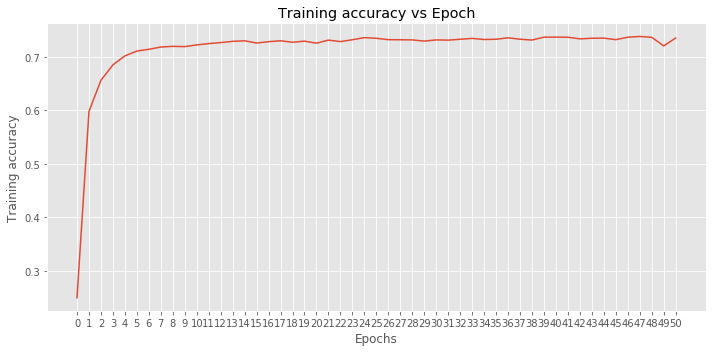

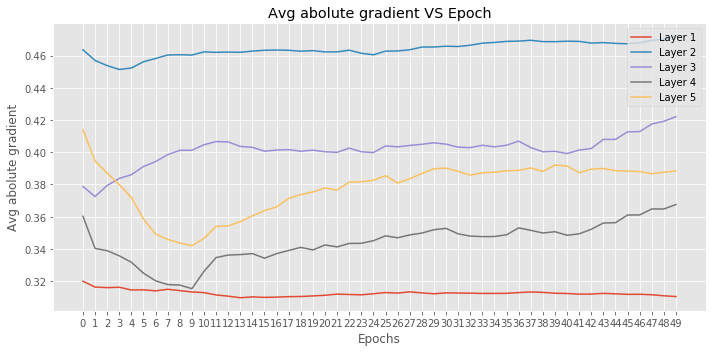

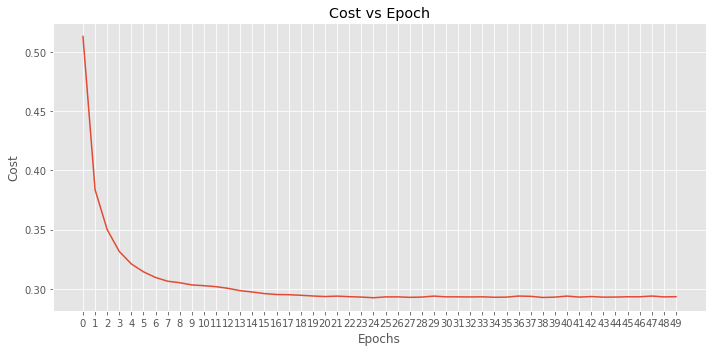

In [193]:
print_n_plot(nn,print_acc=False, print_grad=False, print_cost=False)

### Adaptive Learning Technique
The 3, 4, 5 layer implementations taken from class all had adaptive leanring and momentum built in.  Here we strip it and will then use it in the comparison. 

In [194]:
class FiveLPNoMomentum(object):
    def __init__(self, n_hidden=70, n_hidden2=50, n_hidden3=30, n_hidden4=20, dropout=0.25, clipping=True,
                 C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):
        np.random.seed(random_state)
        self.clipping= clipping
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.n_hidden4 = n_hidden4
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.dropout = dropout
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot    
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden2 + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden3 + self.n_hidden2 + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2 + 1)) 
        W3[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden4 + self.n_hidden3 + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden4, self.n_hidden3 + 1)) 
        W4[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden4 + 1))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden4 + 1)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2)+ np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4, W5):

        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._relu(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._relu(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
      
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = (A6 - Y_enc)  # last layer sensitivity
        V4 = (W5.T @ V5)
        V3 = (W4.T @ V4[1:])
        V2 = (W3.T @ V3[1:])
        V1 = (W2.T @ V2[1:])
        
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        Z3_with_bias = self._add_bias_unit(Z3,how='row')
        Z4_with_bias = self._add_bias_unit(Z4,how='row')
        
        V1[Z1_with_bias<=0] = 0
        V2[Z2_with_bias<=0] = 0
        V3[Z3_with_bias<=0] = 0
        V4[Z4_with_bias<=0] = 0
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T 
        
       # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

    def _clipping(self,grad):
        grad[grad > 0.5] = 0.5
        grad[grad < -0.5] = -0.5
        return grad 
        
    def fit(self, X, y, print_progress=0, XY_test=None, print_grad=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        self.grads_epoch_avg_ = np.zeros((self.epochs, 5))
        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
                  
        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            W3 = self.W3.copy()
            W4 = self.W4.copy()
            W5 = self.W5.copy()
            
            if self.dropout>0.0:
                
                # randomly select half of the neurons
                idx_dropout = np.random.permutation(W1.shape[0])
                idx_dropout = idx_dropout[int(W1.shape[0]*(1-self.dropout)):]
                idx_dropout = np.sort(idx_dropout)
                
                idx2_dropout = np.random.permutation(W2.shape[0])
                idx2_dropout = idx2_dropout[int(W2.shape[0]*(1-self.dropout)):]
                idx2_dropout = np.sort(idx2_dropout)
                
                idx3_dropout = np.random.permutation(W3.shape[0])
                idx3_dropout = idx3_dropout[int(W3.shape[0]*(1-self.dropout)):]
                idx3_dropout = np.sort(idx3_dropout)
                
                idx4_dropout = np.random.permutation(W4.shape[0])
                idx4_dropout = idx4_dropout[int(W4.shape[0]*(1-self.dropout)):]
                idx4_dropout = np.sort(idx4_dropout)
                
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                idx_W3_withbias = np.hstack(([0],(idx2_dropout+1)))
                idx_W4_withbias = np.hstack(([0],(idx3_dropout+1)))
                idx_W5_withbias = np.hstack(([0],(idx4_dropout+1)))
                
                W1 = W1[idx_dropout,:]
                W2 = W2[:,idx_W2_withbias]
                W2 = W2[idx2_dropout,:]
                W3 = W3[:,idx_W3_withbias]
                W3 = W3[idx3_dropout,:]
                W4 = W4[:,idx_W4_withbias]
                W4 = W4[idx4_dropout,:]
                W5 = W5[:,idx_W5_withbias]

            grad1_mini_avg, grad2_mini_avg, grad3_mini_avg, grad4_mini_avg, grad5_mini_avg = [], [], [], [], []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       W1, W2, W3, W4, W5)
                
                cost = self._cost(A6,Y_enc[:, idx],W1,W2,W3,W4,W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                Y_enc=Y_enc[:, idx],
                                                                W1=W1, W2=W2, W3=W3, W4=W4, W5=W5)

                if self.clipping == True:
                    grad1 = self._clipping(grad1)
                    grad2 = self._clipping(grad2)
                    grad3 = self._clipping(grad3)
                    grad4 = self._clipping(grad4)
                    grad5 = self._clipping(grad5)
                    

                delta_W1, delta_W2, delta_W3, delta_W4, delta_W5 = self.eta * grad1, self.eta * grad2, self.eta * grad3, self.eta * grad4, self.eta * grad5
                W1 -= delta_W1
                W2 -= delta_W2
                W3 -= delta_W3
                W4 -= delta_W4
                W5 -= delta_W5   
                                
                #Get gradients for each minibatch
                grad1_mini_avg.append(grad1)
                grad2_mini_avg.append(grad2)
                grad3_mini_avg.append(grad3)
                grad4_mini_avg.append(grad4)
                grad5_mini_avg.append(grad5)
            
            # Mean absolute values for each epoch
            self.grads_epoch_avg_[i][0] = np.mean(np.absolute(grad1_mini_avg))
            self.grads_epoch_avg_[i][1] = np.mean(np.absolute(grad2_mini_avg))
            self.grads_epoch_avg_[i][2] = np.mean(np.absolute(grad3_mini_avg))
            self.grads_epoch_avg_[i][3] = np.mean(np.absolute(grad4_mini_avg))
            self.grads_epoch_avg_[i][4] = np.mean(np.absolute(grad5_mini_avg))

            
            if self.dropout>0.0:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                for i  in range(len(idx2_dropout)):
                    for j in range(len(idx_W2_withbias)):
                        self.W2[idx2_dropout[i],idx_W2_withbias[j]] = W2[i,j]
                        
                for i  in range(len(idx3_dropout)):
                    for j in range(len(idx_W3_withbias)):
                        self.W3[idx3_dropout[i],idx_W3_withbias[j]] = W3[i,j]
                        
                for i  in range(len(idx4_dropout)):
                    for j in range(len(idx_W4_withbias)):
                        self.W4[idx4_dropout[i],idx_W4_withbias[j]] = W4[i,j]
                        
                self.W5[:,idx_W5_withbias] = W5
                
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                self.W3 = W3
                self.W4 = W4
                self.W5 = W5
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost)
                
        return self

In [199]:
nn = FiveLPNoMomentum(**vals2)
nn.fit(X_train.to_numpy(), y_train.to_numpy(), print_progress=50)
yhat_no_momentum = nn.predict(X_test)
print('Accuracy:', accuracy_score(y_test, yhat_no_momentum))
print(confusion_matrix(y_test, yhat_no_momentum))

Epoch: 50/50

Accuracy: 0.7218784378437844
[[2986  586   92   29]
 [ 781 2006  791   55]
 [  64  523 2609  440]
 [  28    5  651 2898]]


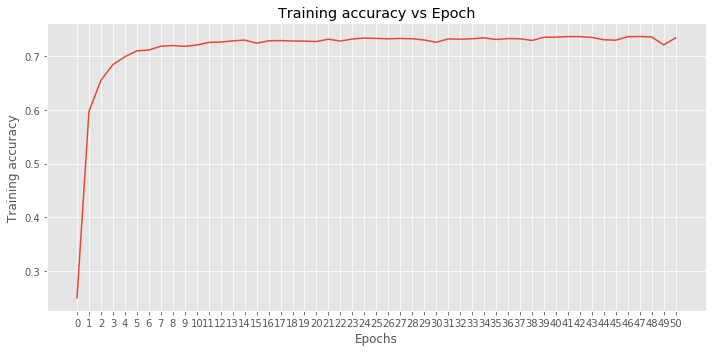

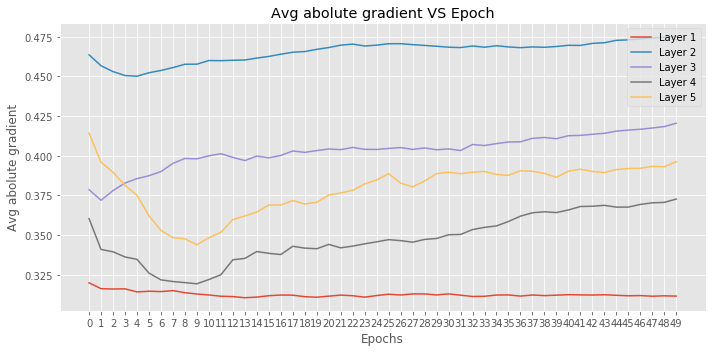

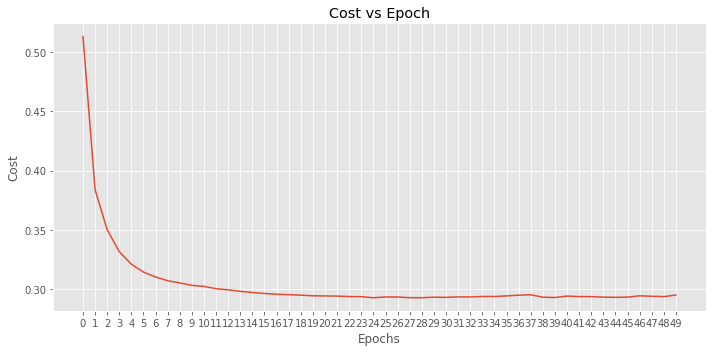

In [200]:
print_n_plot(nn,print_acc=False, print_grad=False, print_cost=False)

In [201]:
y_test = list(y_test)

no_momentum_comp = np.equal(yhat_no_momentum, y_test)
momentum_comp = np.equal(yhat_momentum, y_test)

momentum_no_momentum_table = table_compiler(momentum_comp, no_momentum_comp)
print (momentum_no_momentum_table)


tables = [momentum_no_momentum_table]
tables_titles = ['Momentum vs No Momentum']

for t in range(len(tables)):
    print(tables_titles[t])
    # calculate mcnemar test
    result = mcnemar(tables[t], exact=False)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('No meaningful difference in performance (fail to reject H0)')
        print('-----------------------------------------------------------')
        print()
    else:
        print('Meaningful difference in performance (reject H0)')
        print('------------------------------------------------')
        print()

[[9793.  723.]
 [ 706. 3322.]]
Momentum vs No Momentum
statistic=0.179, p-value=0.672
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------



On top of the comparison using the McNemar test on the prediction of these two models, we noticed that using the momentum did not speed up the convergence of the accuracy as we would have expected. In fact, looking at the plot of the accuracy vs epoch with and without momentum, we observe that the convergence happens roughly at the same point (5 epochs according to the elbow criteria).

# Semi-Exceptional Work (AdAM)

In [216]:
import math

class FiveLPAdam(object):
    def __init__(self, n_hidden=70, n_hidden2=50, n_hidden3=30, n_hidden4=20, dropout=0.25, clipping=True,
                 C=0.0, epochs=500, random_state=None, alpha=0.0, beta_1=0.9, beta_2=0.999,
                 #decrease_const=0.0, 
                 shuffle=True, minibatches=1, **kwds):
        """Adam defaults derived from Kingman & Ba paper
            alpha is in the super class
            beta_1 & beta_2 are the decay rates [0,1)
        """
        np.random.seed(random_state)
        self.clipping= clipping
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.n_hidden4 = n_hidden4
        self.l2_C = C
        self.epochs = epochs
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = 1e-8
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.dropout = dropout
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot    
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden2 + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden3 + self.n_hidden2 + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2 + 1)) 
        W3[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden4 + self.n_hidden3 + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden4, self.n_hidden3 + 1)) 
        W4[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden4 + 1))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden4 + 1)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2)+ np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4, W5):

        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._relu(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._relu(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
      
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = (A6 - Y_enc)  # last layer sensitivity
        V4 = (W5.T @ V5)
        V3 = (W4.T @ V4[1:])
        V2 = (W3.T @ V3[1:])
        V1 = (W2.T @ V2[1:])
        
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        Z3_with_bias = self._add_bias_unit(Z3,how='row')
        Z4_with_bias = self._add_bias_unit(Z4,how='row')
        
        V1[Z1_with_bias<=0] = 0
        V2[Z2_with_bias<=0] = 0
        V3[Z3_with_bias<=0] = 0
        V4[Z4_with_bias<=0] = 0
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T 
        
       # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

    def _clipping(self,grad):
        grad[grad > 0.5] = 0.5
        grad[grad < -0.5] = -0.5
        return grad 
        
    def fit(self, X, y, print_progress=0, XY_test=None, print_grad=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        # Adam initialization
        W1_prev = np.zeros(self.W1.shape)
        W2_prev = np.zeros(self.W2.shape)
        W3_prev = np.zeros(self.W3.shape)
        W4_prev = np.zeros(self.W4.shape)
        W5_prev = np.zeros(self.W5.shape)
        
        m_sub_t_prev_1 = np.zeros(self.W1.shape)
        m_sub_t_prev_2 = np.zeros(self.W2.shape)
        m_sub_t_prev_3 = np.zeros(self.W3.shape)
        m_sub_t_prev_4 = np.zeros(self.W4.shape)
        m_sub_t_prev_5 = np.zeros(self.W5.shape)
        
        v_sub_t_prev_1 = np.zeros(self.W1.shape)
        v_sub_t_prev_2 = np.zeros(self.W2.shape)
        v_sub_t_prev_3 = np.zeros(self.W3.shape)
        v_sub_t_prev_4 = np.zeros(self.W4.shape)
        v_sub_t_prev_5 = np.zeros(self.W5.shape)
        
        self.grads_epoch_avg_ = np.zeros((self.epochs, 5))
        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
          
        t = 0
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            W3 = self.W3.copy()
            W4 = self.W4.copy()
            W5 = self.W5.copy()
            
            if self.dropout>0.0:
                
                # randomly select half of the neurons
                idx_dropout = np.random.permutation(W1.shape[0])
                idx_dropout = idx_dropout[int(W1.shape[0]*(1-self.dropout)):]
                idx_dropout = np.sort(idx_dropout)
                
                idx2_dropout = np.random.permutation(W2.shape[0])
                idx2_dropout = idx2_dropout[int(W2.shape[0]*(1-self.dropout)):]
                idx2_dropout = np.sort(idx2_dropout)
                
                idx3_dropout = np.random.permutation(W3.shape[0])
                idx3_dropout = idx3_dropout[int(W3.shape[0]*(1-self.dropout)):]
                idx3_dropout = np.sort(idx3_dropout)
                
                idx4_dropout = np.random.permutation(W4.shape[0])
                idx4_dropout = idx4_dropout[int(W4.shape[0]*(1-self.dropout)):]
                idx4_dropout = np.sort(idx4_dropout)
                
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                idx_W3_withbias = np.hstack(([0],(idx2_dropout+1)))
                idx_W4_withbias = np.hstack(([0],(idx3_dropout+1)))
                idx_W5_withbias = np.hstack(([0],(idx4_dropout+1)))
                
                W1 = W1[idx_dropout,:]
                W2 = W2[:,idx_W2_withbias]
                W2 = W2[idx2_dropout,:]
                W3 = W3[:,idx_W3_withbias]
                W3 = W3[idx3_dropout,:]
                W4 = W4[:,idx_W4_withbias]
                W4 = W4[idx4_dropout,:]
                W5 = W5[:,idx_W5_withbias]

            grad1_mini_avg, grad2_mini_avg, grad3_mini_avg, grad4_mini_avg, grad5_mini_avg = [], [], [], [], []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       W1, W2, W3, W4, W5)
                
                cost = self._cost(A6,Y_enc[:, idx],W1,W2,W3,W4,W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                Y_enc=Y_enc[:, idx],
                                                                W1=W1, W2=W2, W3=W3, W4=W4, W5=W5)

                if self.clipping == True:
                    grad1 = self._clipping(grad1)
                    grad2 = self._clipping(grad2)
                    grad3 = self._clipping(grad3)
                    grad4 = self._clipping(grad4)
                    grad5 = self._clipping(grad5)
                    
                t += 1
                
                # First layer Momentum
                m_sub_t_1 = self.beta_1 * m_sub_t_prev_1 + (1 - self.beta_1) * grad1
                v_sub_t_1 = self.beta_2 * v_sub_t_prev_1 + (1 - self.beta_2) * grad1**2
                m_hat = m_sub_t_1 / (1 - self.beta_1**t)
                v_hat = v_sub_t_1 / (1 - self.beta_2**t)
                W1 = W1_prev - (self.alpha * m_hat) / (np.sqrt(v_hat) + self.epsilon)
                m_sub_t_prev_1 = m_sub_t_1
                v_sub_t_prev_1 = v_sub_t_1
                W1_prev = W1.copy()
                
                # Second layer
                m_sub_t_2 = self.beta_1 * m_sub_t_prev_2 + (1 - self.beta_1) * grad2
                v_sub_t_2 = self.beta_2 * v_sub_t_prev_2 + (1 - self.beta_2) * grad2**2
                m_hat = m_sub_t_2 / (1 - self.beta_1**t)
                v_hat = v_sub_t_2 / (1 - self.beta_2**t)
                W2 = W2_prev - (self.alpha * m_hat) / (np.sqrt(v_hat) + self.epsilon)
                m_sub_t_prev_2 = m_sub_t_2
                v_sub_t_prev_2 = v_sub_t_2
                W2_prev = W2.copy()        
                    
                # Third Layer
                m_sub_t_3 = self.beta_1 * m_sub_t_prev_3 + (1 - self.beta_1) * grad3
                v_sub_t_3 = self.beta_2 * v_sub_t_prev_3 + (1 - self.beta_2) * grad3**2
                m_hat = m_sub_t_3 / (1 - self.beta_1**t)
                v_hat = v_sub_t_3 / (1 - self.beta_2**t)
                W3 = W3_prev - (self.alpha * m_hat) / (np.sqrt(v_hat) + self.epsilon)
                m_sub_t_prev_3 = m_sub_t_3
                v_sub_t_prev_3 = v_sub_t_3
                W3_prev = W3.copy()         
                
                #Fourth Layer
                m_sub_t_4 = self.beta_1 * m_sub_t_prev_4 + (1 - self.beta_1) * grad4
                v_sub_t_4 = self.beta_2 * v_sub_t_prev_4 + (1 - self.beta_2) * grad4**2
                m_hat = m_sub_t_4 / (1 - self.beta_1**t)
                v_hat = v_sub_t_4 / (1 - self.beta_2**t)
                W4 = W4_prev - (self.alpha * m_hat) / (np.sqrt(v_hat) + self.epsilon)
                m_sub_t_prev_4 = m_sub_t_4
                v_sub_t_prev_4 = v_sub_t_4
                W4_prev = W4.copy()
                
                # Fifth Layer
                m_sub_t_5 = self.beta_1 * m_sub_t_prev_5 + (1 - self.beta_1) * grad5
                v_sub_t_5 = self.beta_2 * v_sub_t_prev_5 + (1 - self.beta_2) * grad5**2
                m_hat = m_sub_t_5 / (1 - self.beta_1**t)
                v_hat = v_sub_t_5 / (1 - self.beta_2**t)
                W5 = W5_prev - (self.alpha * m_hat) / (np.sqrt(v_hat) + self.epsilon)
                m_sub_t_prev_5 = m_sub_t_5
                v_sub_t_prev_5 = v_sub_t_5
                W5_prev = W5.copy()
                                
                #Get gradients for each minibatch
                grad1_mini_avg.append(grad1)
                grad2_mini_avg.append(grad2)
                grad3_mini_avg.append(grad3)
                grad4_mini_avg.append(grad4)
                grad5_mini_avg.append(grad5)
            
            # Mean absolute values for each epoch
            self.grads_epoch_avg_[i][0] = np.mean(np.absolute(grad1_mini_avg))
            self.grads_epoch_avg_[i][1] = np.mean(np.absolute(grad2_mini_avg))
            self.grads_epoch_avg_[i][2] = np.mean(np.absolute(grad3_mini_avg))
            self.grads_epoch_avg_[i][3] = np.mean(np.absolute(grad4_mini_avg))
            self.grads_epoch_avg_[i][4] = np.mean(np.absolute(grad5_mini_avg))

            
            if self.dropout>0.0:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                for i  in range(len(idx2_dropout)):
                    for j in range(len(idx_W2_withbias)):
                        self.W2[idx2_dropout[i],idx_W2_withbias[j]] = W2[i,j]
                        
                for i  in range(len(idx3_dropout)):
                    for j in range(len(idx_W3_withbias)):
                        self.W3[idx3_dropout[i],idx_W3_withbias[j]] = W3[i,j]
                        
                for i  in range(len(idx4_dropout)):
                    for j in range(len(idx_W4_withbias)):
                        self.W4[idx4_dropout[i],idx_W4_withbias[j]] = W4[i,j]
                        
                self.W5[:,idx_W5_withbias] = W5
                
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                self.W3 = W3
                self.W4 = W4
                self.W5 = W5
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost)
                
        return self

In [217]:
nn = FiveLPAdam(**vals2)
nn.fit(X_train.to_numpy(), y_train.to_numpy(), print_progress=50)
yhat_no_momentum = nn.predict(X_test)
print('Accuracy:', accuracy_score(y_test, yhat_no_momentum))
print(confusion_matrix(y_test, yhat_no_momentum))

Epoch: 50/50

Accuracy: 0.6886001100110011
[[3260  330   79   24]
 [1462 1554  570   47]
 [  90  768 2192  586]
 [   8   27  538 3009]]


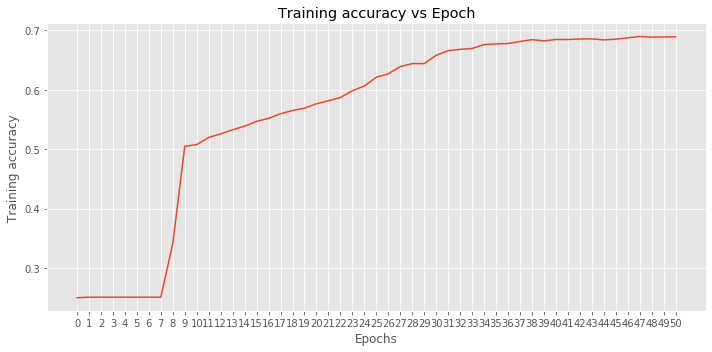

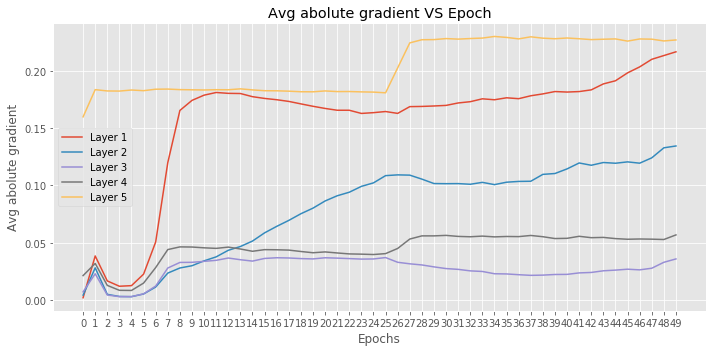

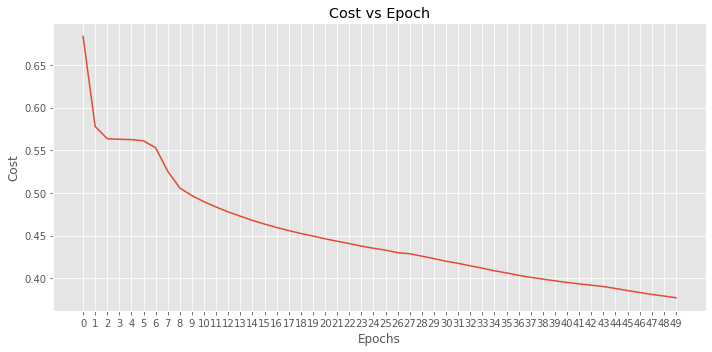

In [218]:
print_n_plot(nn,print_acc=False, print_grad=False, print_cost=False)